In [1]:
import pandas as pd
import numpy as np
from fastai.core import *
from PIL import Image
from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *

In [22]:
import json
from collections import defaultdict
import pdb
import numpy as np

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [57]:
coco = Path('dataset1.v1.coco')
# coco = untar_data('classroomtest.coco.zip')
img_dir = Path('dataset1.v1.coco/images')
annotations_train = Path('dataset1.v1.coco/annotation/train_annotations.coco.json')
annotations_test = Path('dataset1.v1.coco/annotation/test_annotations.coco.json')

# annotation 여기에선 데이터 한꺼번에 불러오길래
# train val images 합쳐서 넣음
images, lbl_bbox = get_annotations(annotations_train)
images_,lbl_bbox_ = get_annotations(annotations_test)
images.extend(images_)
lbl_bbox.extend(lbl_bbox_)


In [67]:
with open(annotations_train) as f:
    train_json = json.load(f)
    
ncat = len(train_json['categories'])
train_json['categories']

[{'id': 0, 'name': 'dataset1', 'supercategory': 'none'},
 {'id': 1, 'name': '1', 'supercategory': 'dataset1'},
 {'id': 2, 'name': '3', 'supercategory': 'dataset1'},
 {'id': 3, 'name': '4', 'supercategory': 'dataset1'},
 {'id': 4, 'name': '5', 'supercategory': 'dataset1'},
 {'id': 5, 'name': '6', 'supercategory': 'dataset1'},
 {'id': 6, 'name': '7', 'supercategory': 'dataset1'},
 {'id': 7, 'name': '8', 'supercategory': 'dataset1'},
 {'id': 8, 'name': '9', 'supercategory': 'dataset1'},
 {'id': 9, 'name': 'eye', 'supercategory': 'dataset1'},
 {'id': 10, 'name': 'eye_close', 'supercategory': 'dataset1'},
 {'id': 11, 'name': 'eye_open', 'supercategory': 'dataset1'},
 {'id': 12, 'name': 'half_close', 'supercategory': 'dataset1'},
 {'id': 13, 'name': 'half_closed', 'supercategory': 'dataset1'},
 {'id': 14, 'name': 'open_eye', 'supercategory': 'dataset1'}]

In [58]:
for idx, lbl in enumerate(lbl_bbox):
    if len(lbl[1]) == 0:
        print(f"found empty annotation: {idx}")

In [60]:
## 돌렸을때 경고문구는 원래그럼. 예제에도 있었음.

img_list = ImageList.from_folder(img_dir)
#image size
sz = 224
# print(len(img_list))

img2bbox = dict(zip(images, lbl_bbox))
# img2bbox.sort()
print(type(images))
# cnt = 0
def get_y_func(o):
    filename = o.name
    if img2bbox.get(o.name):
        return img2bbox[o.name]
    else:
        # 데이터가 다 잘 들어간걸 확인했는데도 자꾸 오류가 나서 넣은 코드
        # 라벨링이 안된 사진이 들어갔을때 나는 오류라서
        # 임의로 bbox 리턴. 데이터 교체하면 오류 없을것.
        return [[[128, 148, 290, 217.5], [152, 162, 170.5, 178]], ['4', 'eye_opened']]

# data = data.label_from_func(get_y_func)
data = (ObjectItemList.from_folder('dataset1.v1.coco/images')
        .split_by_folder()                          
        .label_from_func(get_y_func)
        .transform(get_transforms(), tfm_y=True, size=224)
        .databunch(bs=8, collate_fn=bb_pad_collate, num_workers=0)
        .normalize(imagenet_stats)
       )

data

<class 'list'>


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


ImageDataBunch;

Train: LabelList (605 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: dataset1.v1.coco\images;

Valid: LabelList (173 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: dataset1.v1.coco\images;

Test: None

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


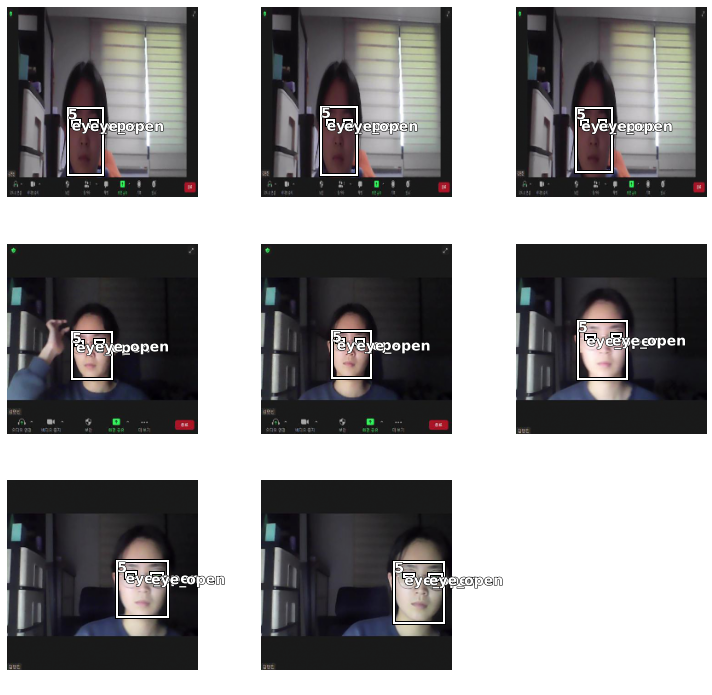

In [61]:
data.show_batch(rows=3, ds_type= np.int64, figsize=(10,10))

In [28]:
# for idx, lbl in enumerate(lbl_bbox):
#     if len(lbl[1]) == 0:
#         print(f"found empty annotation: {idx}")

        
# with open(annotations_train) as f:
#     train_json = json.load(f)

# ncat = len(train_json['categories'])
# train_json['categories']
# custom_head= 만들면 최고....

In [39]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

# str 중심값, bbox 가로세로 메트릭스 연산으로 꼭지점 좌표 구하기
# 그 좌표를 이용해서 anchor 박스보여주기

def create_anchors(ncells=[4], zooms=[1.],ratios=[(1.,1.)]):
    a_scales = [(z*i,z*j) for z in zooms for (i,j) in ratios]
    k = len(a_scales)
    a_x = np.concatenate([np.repeat(np.linspace(-1+1/nc, 1-1/nc, nc), nc) 
                          for nc in ncells])
    a_y = np.concatenate([np.tile(np.linspace(-1+1/nc, 1-1/nc, nc), nc)
                          for nc in ncells])
    a_ctrs = np.repeat(np.stack([a_x, a_y], axis=1), k, axis=0)
    a_sz = np.concatenate([np.array([[2*o/nc,2*p/nc] 
                                     for i in range(nc*nc)
                                     for o,p in a_scales])
                           for nc in ncells])
    grid_sz = np.concatenate([np.array([2/nc 
                                        for i in range(nc*nc)
                                        for o,p in a_scales])
                              for nc in ncells])
    anc = np.concatenate([a_ctrs, a_sz], axis=1)
    grid_sizes = torch.tensor(grid_sz).type(torch.FloatTensor).unsqueeze(1).cuda()
    anchors = torch.tensor(anc).type(torch.FloatTensor).cuda()
    anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
    return anchors, anchor_cnr, grid_sizes

In [62]:
anchors, anchor_cnr, grid_sizes = create_anchors(ncells=[4,2,1],
                                                 zooms=[0.7, 1., 1.3],
                                                 ratios=[(1.,1.), (1., 0.5), (0.5, 1.)])

In [41]:

def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)


In [69]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes=14):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
#         t = t[:,:-1].contiguous().cuda()
#         x = pred[:,:-1]
        # in fastai v1, the background is encoded as the first class, rather than the last one
        t = t[:,1:].contiguous().cuda()
        x = pred[:,1:]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None
    
class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,2.
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return (w * (1-pt).pow(gamma)).detach()

loss_f = FocalLoss(ncat)


In [70]:
# remove padding - 이미지속에 존재하는 오브잭트 수가 각각 달라서 발생하는 문제를 해결하기 위해
# 가장 많은걸 기준으로 0으로 패딩 넣음

def get_y(bbox,clas):
    bbox = bbox.view(-1,4)
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def ssd_1_loss(pred_bbox,pred_clas,bbox,clas):
    bbox,clas = get_y(bbox,clas)
    if len(bbox) == 0 and len(clas) == 0:
        return 0.0, 0.0
    a_ic = actn_to_bb(pred_bbox, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,False)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[~pos] = 0 # background coded as 0
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(pred_clas, gt_clas)
    #print(f"loc_loss: {loc_loss}, clas_loss: {clas_loss}")
    return loc_loss, clas_loss

def ssd_loss(pred,targ_bb,targ_c):
    lcs,lls = 0.,0.
#    i = 1
#    for b_c,b_bb,bbox,clas in zip(*pred,targ_bb,targ_c):
    for pr_bb, pr_c, ta_bb, ta_c in zip(*pred, targ_bb, targ_c):
#         print(f"item {i}")
#         if i == 5:
#             pdb.set_trace()
#         i = i+1
#        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas)
        loc_loss, clas_loss = ssd_1_loss(pr_bb, pr_c, ta_bb, ta_c)
        lls += loc_loss
        lcs += clas_loss
#    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return 20*lls+lcs

In [71]:
# 모델 헤드

class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))

def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, 4*k, 3, padding=1) # first bboxes
        self.oconv2 = nn.Conv2d(nin, (ncat+1)*k, 3, padding=1) # than class labels
        self.oconv2.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
#         self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
#         x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)
    
class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        drop = 0.4
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv0 = StdConv(512,256, stride=1, drop=drop)
        self.sconv1 = StdConv(256,256, drop=drop)
        self.sconv2 = StdConv(256,256, drop=drop)
        self.sconv3 = StdConv(256,256, drop=drop)
        self.out0 = OutConv(k, 256, bias)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        o2c,o2l = self.out2(x)
        x = self.sconv3(x)
        o3c,o3l = self.out3(x)
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1)]

In [72]:
head_reg4 = SSD_MultiHead(9, bias= -3.)
learn = cnn_learner(data, models.resnet18, loss_func=ssd_loss, custom_head=head_reg4)

learn.summary()

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

epoch,train_loss,valid_loss,time
0,371.252441,#na#,00:24


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


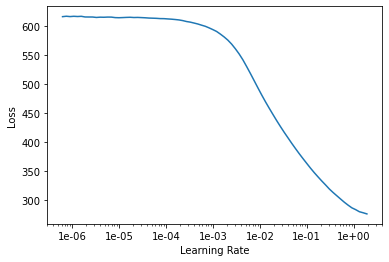

In [73]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e+00
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,time
0,96.744514,75.928757,00:24
1,1547.910767,947751872.000000,00:25
2,4234.665527,338009920.000000,00:24
3,2975.381592,1519.880371,00:25
4,1164.048340,216.662140,00:25
5,488.970978,80.632805,00:24
6,254.858658,142.883347,00:25
7,159.181610,184.869965,00:25
8,197.937790,183779.421875,00:25


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

In [ ]:
learn.save('stage1-focal-loss')

In [ ]:
def corners2hw(corners): return torch.cat([corners[:,:2], corners[:,2:] - corners[:,:2]], dim=1)
def show_results(max_show=0, printit=False):
    if max_show == 0:
        max_show = len(data.valid_ds)
    else:
        max_show = min(max_show, len(data.valid_ds))
    figsize = (10, max_show*5)
    fig,axs = plt.subplots(max_show, 2, figsize=figsize)
    i = 0
    while i < max_show:
        img, label = data.valid_ds[i]
        img.show(ax=axs[i,0], y=label, figsize=(5,5))        
        x, y = data.one_item(img)
        pred_bb, pred_cc = learn.model(x)
        pred_cc = pred_cc.squeeze() # remove the singleton batch dimension
        pred_bb = pred_bb.squeeze()
        pred_clas = pred_cc.max(1)[1] # get the index of the max as the predicted clas
        pred_clas_prob = pred_cc.max(1)[0].sigmoid() # get the sigmoid of the max as the class probability
        pos_idx = pred_clas > 0
#         if i == 1:
#             pdb.set_trace()
        a_ic = actn_to_bb(pred_bb, anchors)
        anc_cnr = anchor_cnr.clone()
        if printit:
            print(f"i={i}, a_ic orig")
            print(a_ic[pos_idx])
            print(f"i={i}, anchor orig")
            print(anc_cnr[pos_idx])
        h = 224
        w = 224
        # convert to image coordinates (add 1 and scale by img size)
        a_ic.add_(1)
        anc_cnr.add_(1)
        if printit:
            print(f"i={i}, a_ic moved")
            print(a_ic[pos_idx])
            print(f"i={i}, anchor moved")
            print(anc_cnr[pos_idx])        
        a_ic.mul_(torch.tensor([h/2, w/2, h/2, w/2]).cuda()).long()
        anc_cnr.mul_(torch.tensor([h/2, w/2, h/2, w/2]).cuda()).long()
        if printit:
            print(f"i={i}, a_ic rescaled")
            print(a_ic[pos_idx])
            print(f"i={i}, anchor rescaled")
            print(anc_cnr[pos_idx])
        # select only bboxes that detect something else than background (0)
        pos_pred_clas = pred_clas[pos_idx]
        pos_a_ic = a_ic[pos_idx]
        if len(pos_pred_clas) > 0:
#             if i == 1:
#                 pdb.set_trace()
            pred_label = ImageBBox.create(224, 224, pos_a_ic.cpu(), pos_pred_clas.cpu(), data.train_ds.y.classes)
            img.show(ax=axs[i,1], y=pred_label, figsize=(5,5))
        else:
            img.show(ax=axs[i,1], figsize= (5,5))
        i = i+1

In [ ]:
show_results(max_show=100, printit=False)

In [ ]:
learn.export()

In [ ]:
img = open_image('WIN_20210131_03_09_21_Pro-058_jpg.rf.3551bfdc120ed519174f5d1e44b2fe05.jpg')
img

In [ ]:
path = Path()
learn = load_learner(path)

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)

pred_class.obj
